# CNN Implementation using Numpy

In [0]:
import random
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from google.colab import drive
drive.mount('/gdrive')

## 1. MNIST Data preparation

In [3]:
mnist = np.load("/gdrive/My Drive/Colab Notebooks/mnist.npz")
mnist.keys()

['x_test', 'x_train', 'y_train', 'y_test']

In [4]:
x_train = mnist["x_train"]
y_train = mnist["y_train"]
x_test = mnist["x_test"]
y_test = mnist["y_test"]
#Data normalization
x_train = x_train.astype('float64')
x_test = x_test.astype('float64')
x_train -= np.mean(x_train,axis=0)
x_test -= np.mean(x_test,axis=0)

#reshaping channels
N,h,w = x_train.shape
x_train = x_train.reshape((N,h,w,1))
N,h,w = x_test.shape
x_test = x_test.reshape((N,h,w,1))

print("x_train shape:",x_train.shape)
print("x_test shape:",x_test.shape)

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


## 2. Smaller dataset for training on local machine

In [0]:
N_train = 6000
X_train = x_train[:N_train]
Y_train = y_train[:N_train]
N_test = 1000
X_test = x_test[:N_test]
Y_test = y_test[:N_test]

## 3. Utility functions

### a) Img2col function

In [0]:
def img2col_indices(input_shape,filter_height,filter_width,stride=1):
    #input_shape: (H=height,W=width,D=depth)
    input_channels = input_shape[2];
    F_h = filter_height
    F_w = filter_width
    
    assert((input_shape[1]-F_w)%stride==0)
    assert((input_shape[0]-F_h)%stride==0)
    
    w_out = (input_shape[1]-F_w)//stride + 1
    h_out = (input_shape[0]-F_h)//stride + 1
    
    L = w_out*h_out
    
    i = np.tile(np.repeat(np.arange(F_h),F_w),L*input_channels) + \
        np.repeat(np.arange(h_out),F_h*F_w*w_out*input_channels)*stride
    
    j = np.tile(np.arange(F_w),F_h*L*input_channels) + \
        np.tile(np.repeat(np.arange(w_out),F_h*F_w*input_channels),h_out)*stride
    
    k = np.tile(np.repeat(np.arange(input_channels),F_h*F_w),L)
    return i,j,k

def img2col(X,filter_height,filter_width,stride=1,padding=0):
    #X shape: (N=number of images,H,W,D)
    (N,H,W,D) = X.shape
    Y = np.zeros((N,H+2*padding,W+2*padding,D))
    Y[:,padding:padding+H,padding:padding+W,:] = X
    X = Y
    indices = img2col_indices(X[0].shape,filter_height,filter_width,stride) #get Index array
    channel = D #Number of channels in input
    X_row = X[:,indices[0],indices[1],indices[2]]
    X_col = np.transpose(X_row.reshape((N,-1,filter_width*filter_height*channel)),(0,2,1))
    return X_col

In [0]:
def kernel2col(W):
    #input parameter kernel of shape (no. of filters, height,width,channels or depth)
    #W_ = np.transpose(W,(3,0,1,2))
    (K,F_h,F_w,D)=W.shape
    W_col = img2col(W,F_h,F_w) #parameter filter_size = size of input
    W_col = np.squeeze(W_col).T
    return W_col

### b) Convolution Feedforward

In [0]:
def conv_forward(X,W,bias=0,stride=1,padding=0):
    #shape of bias: (1,K)
    
    N,w,h,c = X.shape
    K,filter_height,filter_width,d = W.shape
    
    assert(c==d)
    X_col = img2col(X,filter_height,filter_width,stride,padding)
    W_col = kernel2col(W)
    
    assert(bias.shape[1]==W.shape[0])
    #convolution
    Z_col = np.dot(np.transpose(X_col,(0,2,1)),W_col) + bias
    
    assert((w-filter_width+2*padding)%stride==0)
    assert((h-filter_height+2*padding)%stride==0)
    
    w_out = (w-filter_width+2*padding)//stride + 1
    h_out = (h-filter_height+2*padding)//stride + 1
    
    #Z = col2img(Z_col,h_out,w_out)
    Z =  Z_col.reshape(Z_col.shape[0],h_out,w_out,Z_col.shape[2])
    return Z

### c) Convolution Backprop

In [0]:
def img2col_backward(X,filter_height,filter_width,stride=1,padding=0):
    #X shape: (N=batch size,C=number of images in one set,H,W,D=1)
    N,C,H,W,D = X.shape
    Y = np.zeros((N,C,H+2*padding,W+2*padding,D))
    Y[:,:,padding:padding+H,padding:padding+W,:] = X
    X = Y
    indices = img2col_indices((H+2*padding,W+2*padding,D),filter_height,filter_width,stride) #get Index array
    channel = D #Number of channels in input
    X_row = X[:,:,indices[0],indices[1],indices[2]]
    X_col = np.transpose(X_row.reshape((N,C,-1,filter_height*filter_width*channel)),(0,1,3,2))
    return X_col

def kernel2col_backward(W):
    N,K,h,w,D = W.shape
    W_col = img2col_backward(W,h,w) #parameter filter_size = size of input
    #print("W_col shape: ",W_col.shape)
    W_col = np.squeeze(W_col,axis=3).transpose((0,2,1))
    shp = W_col.shape
    #print(shp)
    assert(N==shp[0])
    assert(h*w==shp[1])
    assert(K==shp[2])
    return W_col

def conv_backward(X,W,dZ,stride=1,padding=0):
    """@Shape of X:(N,h,w,c)
       @Shape of dZ:(N,h_out,h_out,K)
                   K=number of filters
       @Returns: dW,db,dX 
    """
    N1,h,w,c = X.shape
    K,F_h,F_w,c = W.shape
    N2,h_out,w_out,K = dZ.shape
    
    assert(N1==N2)
    X_ = (np.transpose(X,(0,3,1,2))).reshape((N1,c,h,w,1))
    dZ_ = (np.transpose(dZ,(0,3,1,2))).reshape((N2,K,h_out,w_out,1))
    
    X_col = img2col_backward(X_,h_out,w_out,stride,padding)
    dZ_col = kernel2col_backward(dZ_)
    
    dW = np.einsum('ijkl,ilm->ijkm',X_col.transpose((0,1,3,2)),dZ_col)
    F_h = (h-h_out)//stride + 1
    F_w = (w-w_out)//stride + 1
    dW = np.transpose(dW.reshape((N1,c,F_h,F_w,K)),(0,4,2,3,1))
    dW = 1/N1*(np.sum(dW,axis=0))
    
    db = 1/N2*( np.sum(dZ,(0,1,2)).reshape((1,-1)) )
    
    #for calculating dX
    dZ_ = (np.transpose(dZ,(0,3,1,2))).reshape((N2,K,h_out,w_out,1))
    dZ_col = img2col_backward(dZ_,F_h,F_w,1,F_h-1)
    assert(dZ_col.shape[0]==N2)
    assert(dZ_col.shape[1]==K)
    assert(dZ_col.shape[2]==F_h*F_w) #F_h=F_w    
    assert(dZ_col.shape[3]==h*w)
    
    #reshaping and flipping kernels
    W_ = np.transpose(W,(0,3,1,2)).reshape((K,c,F_h,F_w,1))
    W_ = np.flip(W_,2)
    W_ = np.flip(W_,3)
    
    W_col = kernel2col_backward(W_)
    assert(W_col.shape[0]==K)
    assert(W_col.shape[1]==F_h*F_w)
    assert(W_col.shape[2]==c)
    
    dX = np.empty((N2,K,h*w,c))
    for i in range(N2):
        for j in range(K):
            dX[i,j] = np.dot(dZ_col[i,j].T,W_col[j])
    
    dX = dX.reshape((N1,K,h,w,c))
    dX = np.sum(dX,axis=1)
    assert(dX.shape==X.shape)
    return dW, db, dX

### d) ReLu Feedforward and Backprop

In [0]:
def ReLu_forward(X):
    Z = np.maximum(X,0)
    return Z

def ReLu_backward(X,dZ):
    assert(X.shape==dZ.shape)
    dX = np.multiply(dZ,X>0)
    return dX

### e) MaxPool Feedforward

In [0]:
def maxPool_forward(X,filter_size=2,stride=2):
    N,H,W,C = X.shape
    F = filter_size
    #Checking for invalid stride
    assert((H-F)%stride==0)
    assert((W-F)%stride==0)
    w_out = (W-F)//stride + 1
    h_out = (H-F)//stride + 1
    
    #Change depth of input to 1
    Z_ = np.transpose(X,(0,3,1,2)).reshape((N*C,H,W,1))
    Z_col = img2col(Z_,F,F,stride)
    
    Z_col = np.transpose(Z_col,(1,0,2)).reshape((4,-1)) #now shape of Z_col is (4,N*C*w_out*h_out)
    max_indx = np.argmax(Z_col,axis=0)
    
    Z = Z_col[max_indx,range(max_indx.size)] #shape (N*C*w_out*h_out,)
    
    Z = np.transpose(Z.reshape((N,C,h_out,w_out)),(0,2,3,1))
    
    #just for debugging
    N_prime,H_prime,W_prime,C_prime = Z.shape
    assert(N_prime==N)
    assert(H_prime==h_out)
    assert(W_prime==w_out)
    assert(C_prime==C)
    
    return Z, max_indx #shape of max_indx: (N*C*w_out*h_out,)

### f) MaxPool Backprop

In [0]:
def maxPool_backward(max_indx,dZ):
    """Shape of max_indx: (N*C*(h/2)*(w/2), )
       Shape of dZ: (N,h/2,w/2,C)
       returns dX of size (N,h,w,C)
    """
    assert(max_indx.size==dZ.size)
    N,Hz,Wz,C = dZ.shape
    h = Hz*2
    w = Wz*2
    dZ = np.transpose(dZ,(0,3,1,2)).reshape((N*C*Hz*Wz,)) #shape: (N*C*(h/2)*(w/2), )
    dX_col = np.zeros((4,max_indx.size))
    dX_col[max_indx,range(max_indx.size)] = dZ
    
    #restoring dX(N,h,w,C) from dX_col(4,_) 
    dX_col = np.transpose(dX_col.reshape((4,N*C,Hz*Wz)),(1,0,2)) #now shape: (N*C,4,(h/2)*(w/2))
    
    i = np.repeat(np.arange(N*C),4*(h//2)*(w//2))
    j = np.tile(np.array([0,1]),2*(h//2)*(w//2))+np.tile(np.repeat(np.array([0,2]),w),h//2)
    j = np.tile(j,N*C)
    
    k = np.tile(np.repeat(np.arange(w//2),2),h)+np.repeat(np.arange(h//2)*(w//2),2*w)
    k = np.tile(k,N*C)
    
    dX = dX_col[i,j,k]
    #dX = dX.reshape((N*C,h,w))
    dX = np.transpose(dX.reshape((N,C,h,w)),(0,2,3,1)) #now shape is: (N,h,w,C)
    
    return dX

### g) Fully connected Feedforward and Backprop

In [0]:
def fully_connected_forward(X,W,bias=0):
    if len(X.shape)>2:
        N,h,w,c = X.shape
        X = np.transpose(X.reshape((N,h*w*c)),(1,0))
    assert(W.shape[1]==X.shape[0])
    Z = np.dot(W,X)+bias
    input_shape = (N,h,w,c)
    return Z,X,input_shape

def fully_connected_backward(X,y,W,prob,input_shape):
    _,N = prob.shape
    dZ = prob.copy()
    dZ[y,np.arange(N)]-=1
    
    dW = (1/N)*np.dot(dZ,X.T)
    db = (1/N)*np.sum(dZ,axis=1,keepdims=True)
    dX = np.dot(W.T,dZ)
    dX = dX.T.reshape(input_shape)
    return dW,db,dX

### h) Softmax

In [0]:
def softmax(scores,y=None):
    C,N = scores.shape
    scores = scores-np.max(scores,axis=0)
    expProb = np.exp(scores)
    prob = expProb/np.sum(expProb,axis=0)
    cost=0
    if np.any(y!=None):
        cost = -(1/N)*np.sum(np.log(prob[y,range(N)]+1e-8))
    
    return prob,cost

## 4. convNet Class(Fixed architecture)

![Cnn Architecture used](cnn_mnist.jpg")

### Reference for architecture: https://github.com/zishansami102/CNN-from-Scratch

In [0]:
class convNet:
    def __init__(self,stride=1):
        self.stride = stride
        self.W1 = np.random.randn(8,5,5,1)*0.01
        self.b1 = np.zeros((1,8))
        self.W2 = np.random.randn(8,5,5,8)*0.01
        self.b2 = np.zeros((1,8))
        self.W3 = np.random.randn(10,800)*0.01
        self.b3 = np.zeros((10,1))
        self.cache = [0,0,0,0,0,0]
    def feedforward(self,X,y=None):
        self.cache[0]=X
        Z1 = conv_forward(X,self.W1,self.b1,self.stride)
        self.cache[1]=Z1
        Z2 = ReLu_forward(Z1)
        self.cache[2]=Z2
        Z3 = conv_forward(Z2,self.W2,self.b2,self.stride)
        self.cache[3]=Z3
        Z4 = ReLu_forward(Z3)
        Z5,max_indx = maxPool_forward(Z4)
        self.cache[4]=max_indx
        Z6,z,input_shape = fully_connected_forward(Z5,self.W3,self.b3)
        self.cache[5]=(z,input_shape)
        prob,cost = softmax(Z6,y)
        return prob,cost
    
    def backprop(self,prob,y):
        dZ = 0
        grad={}
        grad["dW3"],grad["db3"],dZ = fully_connected_backward(self.cache[5][0],y,self.W3,prob,self.cache[5][1])
        dZ = maxPool_backward(self.cache[4],dZ.copy())
        dZ = ReLu_backward(self.cache[3],dZ.copy())
        grad["dW2"],grad["db2"],dZ = conv_backward(self.cache[2],self.W2,dZ,self.stride)
        dZ = ReLu_backward(self.cache[1],dZ.copy())
        grad["dW1"],grad["db1"],dZ = conv_backward(self.cache[0],self.W1,dZ,self.stride)
        
        return grad
    
    def update(self,grad,learning_rate=0.01):
        self.W1 = self.W1 - learning_rate*grad["dW1"]
        self.W2 = self.W2 - learning_rate*grad["dW2"]
        self.W3 = self.W3 - learning_rate*grad["dW3"]
        self.b1 = self.b1 - learning_rate*grad["db1"]
        self.b2 = self.b2 - learning_rate*grad["db2"]
        self.b3 = self.b3 - learning_rate*grad["db3"]
    
    def train(self,X,y,batch_size=64,learning_rate=0.01,epoch=2):
        (N,h,w,c) = X.shape
        no_of_batches = N//batch_size
        iteration=0
        cost_history = [[],[]]
        for e in range(epoch):
            for b in range(no_of_batches):
                index = np.random.randint(0,N,batch_size)
                batch = X[index]
                batch_y = y[index]
                prob,cost = self.feedforward(batch,batch_y)
                if(iteration%10==0):
                    #np.savez("Weights",W1=self.W1,b1=self.b1,W2=self.W2,b2=self.b2,W3=self.W3,b3=self.b3)
                    cost_history[0].append(iteration)
                    cost_history[1].append(cost)
                    print("Epoch ",e,",Iteration ",iteration," Cost:",cost)
                
                grad = self.backprop(prob,batch_y)
                self.update(grad,learning_rate)
                iteration = iteration+1
        np.savez("trained_model",stride=self.stride,W1=self.W1,b1=self.b1,W2=self.W2,b2=self.b2,W3=self.W3,b3=self.b3)
        return cost_history
    
    def predict(self,X):
        if len(X.shape)==3:
            h,w,c = X.shape
            X = X.reshape((1,h,w,c))
        prob,cost = self.feedforward(X)
        pred = np.argmax(prob,axis=0)
        return pred
    
    def load_pretrained_model(self,path):
        #Weights format: stride,W1,b1,W2,b2,W3,b3
        w = np.load(path)
        self.stride = w["stride"]
        self.W1 = w["W1"]
        self.b1 = w["b1"]
        self.W2 = w["W2"]
        self.b2 = w["b2"]
        self.W3 = w["W3"]
        self.b3 = w["b3"]
        

## 5. Creating convNet object

In [0]:
cnn = convNet()

### Training Network

In [17]:
cost_history = cnn.train(x_train,y_train,batch_size=600,learning_rate=0.01)

Epoch  0 ,Iteration  0  Cost: 2.3060562193018965
Epoch  0 ,Iteration  10  Cost: 2.1204114153908993


KeyboardInterrupt: ignored

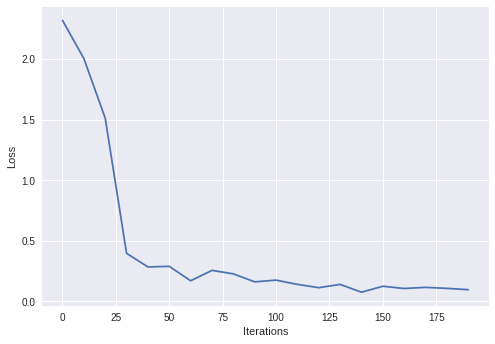

In [27]:
plt.plot(cost_history[0],cost_history[1])
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.savefig("cnngraph.jpg")
plt.show()

In [0]:
y_hat = cnn.predict(x_test)

In [29]:
accuracy = (np.sum(y_hat==y_test)/y_hat.size)*100
print("Accuracy: ",accuracy,"%")

Accuracy:  97.26 %


## 6. Using saved model

In [46]:
cnn.load_pretrained_model('trained_model.npz')
pred = cnn.predict(x_test)
accuracy = (np.sum(pred==y_test)/pred.size)*100
print("Accuracy: ",accuracy,"%")

Accuracy:  97.26 %


## Predicting single random image

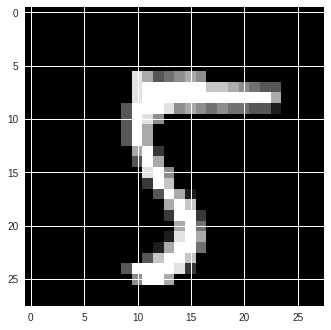

[5]


In [45]:
i=random.randint(0,x_test.shape[0])
x=x_test[i]
plt.imshow(mnist["x_test"][i],cmap='gray')
plt.show()
y_hat = cnn.predict(x)
print(y_hat)